# Изучение данных

- [Гипотеза №1](#hypothesis1)
- [Гипотеза №2](#hypothesis2)
- [Гипотеза №3](#hypothesis3)

## Подготовка

In [1]:
!pip install Faker


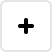
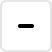
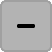
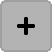
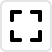
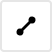
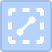
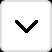
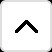
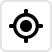

In [2]:
import numpy as np
import pandas as pd
import wx

from lets_plot import *
from lets_plot.mapping import as_discrete
LetsPlot.setup_html()

In [3]:
ACTUAL_FONT_FACES = [
    "Courier",
    "Geneva",
    "Georgia",
    "Helvetica",
    "Lucida Grande",
    "Times New Roman",
    "Verdana",
]

In [4]:
def plot_matrix(plots=[], width=400, height=300, columns=2):
    bunch = GGBunch()
    for i in range(len(plots)):
        row = int(i / columns)
        column = i % columns
        bunch.add_plot(plots[i], column * width, row * height, width, height)
    return bunch.show()

In [5]:
char_widths_df = pd.read_csv("../data/char_widths.csv")
char_widths_df = char_widths_df[char_widths_df.font_face.isin(ACTUAL_FONT_FACES)]
char_widths_df.fillna("", inplace=True)
char_widths_df.head()

char_id char     alphabet font_face  font_size font_version  width
0       65    A  basic_latin   Courier          9                   9
1       66    B  basic_latin   Courier          9                   9
2       67    C  basic_latin   Courier          9                   9
3       68    D  basic_latin   Courier          9                   9
4       69    E  basic_latin   Courier          9                   9

<a class="anchor" id="hypothesis1"></a>
## Гипотеза №1: За размер и версию шрифта отвечает один коэффициент

В первом типе графиков чем выше "ящики" - тем хуже вариация шрифта будет предсказываться по базовой версии (20pt, без искажений). И наоборот, полностью вырожденный в отрезок "ящик" означает, что достаточно знать коэффициенты толщины символов лишь для базовой версии шрифта, чтобы данную вариацию получить домножением на определённый коэффициент.

Во втором типе графиков чем дальше точки от сглаживающей прямой - тем, опять же, хуже для предсказаний.

Первая пара графиков относится к вариациям шрифтов по размеру, вторая - по жирности и курсивности.

Действительно хорошие предсказания по размеру относятся только к моноширинным Courier и Lucida Console, плюс некоторые дополнительные исключения.

По жирности и курсивности также отличается Courier, а для не-латиницы - ещё и Brush Script MT. В целом, создаётся впечатление, что жирность более просто пересчитывается, чем курсивность.

В целом, если хочется иметь единое решение, лучше иметь отдельную модель не только для каждого шрифта, но также для каждого его состояния - для других размеров, а также для жирной и курсивной версий.

In [6]:
def get_font_widths(df, font_size, font_version):
    return df[
        (df.font_size == font_size) &
        (df.font_version == font_version)
    ][["char", "alphabet", "font_face", "width"]]\
        .sort_values(["alphabet", "font_face", "width", "char"])\
        .reset_index(drop=True)

def get_variants_by_size(df, basic_size=20, basic_version=""):
    return pd.concat(
        [pd.merge(get_font_widths(df, basic_size, basic_version),
                  get_font_widths(df, font_size, basic_version),
                  on=["char", "alphabet", "font_face"],
                  suffixes=("_basic", "_variant"))\
             .assign(width_ratio=lambda x: x.width_variant / x.width_basic, \
                     font_size_basic=lambda x: basic_size, \
                     font_size_variant=lambda x: font_size)
         for font_size in df.font_size.unique() if font_size != basic_size]
    ).reset_index(drop=True)

def get_variants_by_version(df, basic_size=20, basic_version=""):
    return pd.concat(
        [pd.merge(get_font_widths(df, basic_size, basic_version),
                  get_font_widths(df, basic_size, font_version),
                  on=["char", "alphabet", "font_face"],
                  suffixes=("_basic", "_variant"))\
             .assign(width_ratio=lambda x: x.width_variant / x.width_basic, \
                     font_version_basic=lambda x: basic_version, \
                     font_version_variant=lambda x: font_version)
         for font_version in df.font_version.unique() if font_version != basic_version]
    ).reset_index(drop=True)

In [7]:
vbs_df = get_variants_by_size(char_widths_df)
vbs_df.head()

char     alphabet font_face  width_basic  width_variant  width_ratio  \
0       basic_latin   Courier           12              9         0.75   
1    !  basic_latin   Courier           12              9         0.75   
2    "  basic_latin   Courier           12              9         0.75   
3    #  basic_latin   Courier           12              9         0.75   
4    $  basic_latin   Courier           12              9         0.75   

   font_size_basic  font_size_variant  
0               20                  9  
1               20                  9  
2               20                  9  
3               20                  9  
4               20                  9

In [8]:
ggplot(vbs_df, aes("font_size_variant", "width_ratio")) + \
    geom_boxplot(aes(group="alphabet", fill="alphabet"), \
                 tooltips=layer_tooltips().line("Alphabet|@alphabet")\
                                          .line("Font face|@font_face")\
                                          .line("Variant of font size|@font_size_variant")\
                                          .line("Basic font size|@font_size_basic"), \
                 show_legend=False) + \
    facet_grid(y="font_face") + \
    ggsize(1000, 4000)

In [9]:
plots = [
    ggplot(vbs_df[vbs_df.font_face == font_face], aes("width_basic", "width_variant")) + \
        geom_point(shape=21, color="black", fill="#3182bd") + \
        geom_smooth(color="#de2d26") + \
        facet_grid(x="alphabet", y="font_size_variant") + \
        ggtitle(font_face)
    for font_face in vbs_df.font_face.unique()
]

plot_matrix(plots, width=1000, height=1000, columns=1)

In [10]:
vbv_df = get_variants_by_version(char_widths_df)
vbv_df.head()

char     alphabet font_face  width_basic  width_variant  width_ratio  \
0       basic_latin   Courier           12             13     1.083333   
1    !  basic_latin   Courier           12             13     1.083333   
2    "  basic_latin   Courier           12             13     1.083333   
3    #  basic_latin   Courier           12             13     1.083333   
4    $  basic_latin   Courier           12             13     1.083333   

  font_version_basic font_version_variant  
0                                       b  
1                                       b  
2                                       b  
3                                       b  
4                                       b

In [11]:
ggplot(vbv_df, aes("font_version_variant", "width_ratio")) + \
    geom_boxplot(aes(group="alphabet", fill="alphabet"), \
                 tooltips=layer_tooltips().line("Alphabet|@alphabet")\
                                          .line("Font face|@font_face")\
                                          .line("Variant of font version|@font_version_variant")\
                                          .line("Basic font version|@font_version_basic"), \
                 show_legend=False) + \
    facet_grid(y="font_face") + \
    ggsize(1000, 4000)

In [12]:
plots = [
    ggplot(vbv_df[vbv_df.font_face == font_face], aes("width_basic", "width_variant")) + \
        geom_point(shape=21, color="black", fill="#3182bd") + \
        geom_smooth(color="#de2d26") + \
        facet_grid(x="alphabet", y="font_version_variant") + \
        ggtitle(font_face)
    for font_face in vbs_df.font_face.unique()
]

plot_matrix(plots, width=1000, height=1000, columns=1)

<a class="anchor" id="hypothesis2"></a>
## Гипотеза №2: Целое равно сумме своих частей

Из графика этого раздела видно, что для греческого и японского алфавитов ширина текста не равна сумме ширин составляющих его символов.

Для базовой латиницы и кириллицы несостыковки возникают только для курсивных версий шрифтов. Courier и Brush Script MT являются исключениями, для которых наиболее хорошо работают предсказания ширины по отдельным символам.

In [13]:
def get_width_dict(df):
    return df.set_index("char").to_dict()["width"]

def size_in_px(text, font_face="Arial", font_size=11, bold=False, italic=False):
    _ = wx.App()

    font_info = wx.FontInfo(font_size).FaceName(font_face)
    if bold:
        font_info = font_info.Bold()
    if italic:
        font_info = font_info.Italic()
    font = wx.Font(font_info)

    screen_dc = wx.ScreenDC()
    screen_dc.SetFont(font)
    size = screen_dc.GetTextExtent(text)

    return size

def get_estimated_texts(font_widths_df, alphabet, font_face="Arial", font_size=11, bold=False, italic=False, size=1000, random_state=42):
    from faker import Faker

    LOCALES = {
        "basic_latin": "en_US",
        "russian": "ru_RU",
        "greek": "el_GR",
        "japanese_hiragana": "ja_JP",
    }
    Faker.seed(random_state)
    fake = Faker(locale=LOCALES[alphabet])
    df = pd.DataFrame({"text": [fake.paragraph(nb_sentences=1) for _ in range(size)]})
    df["actual_width"] = df.text.apply(lambda s: size_in_px(s, font_face, font_size, bold, italic)[0])
    width_dict = get_width_dict(font_widths_df)
    df["estimated_width"] = df.text.apply(lambda t: np.array([(width_dict[c] if c in width_dict.keys() else 0) for c in t]).sum())

    return df

def get_estimation_errors(df):
    data = {
        "alphabet": [],
        "font_face": [],
        "font_size": [],
        "font_version": [],
        "error": [],
    }
    for t in df.groupby(["alphabet", "font_face", "font_size", "font_version"]).count().index:
        alphabet, font_face, font_size, font_version = t
        font_widths_df = get_font_widths(df, font_size, font_version)
        font_widths_df = font_widths_df[(font_widths_df.alphabet == alphabet)&(font_widths_df.font_face == font_face)]
        bold = "b" in font_version
        italic = "i" in font_version
        estimated_texts_df = get_estimated_texts(font_widths_df, alphabet, font_face=font_face, font_size=font_size, bold=bold, italic=italic)
        error = np.abs(estimated_texts_df.actual_width - estimated_texts_df.estimated_width).sum()
        data["alphabet"] += [alphabet]
        data["font_face"] += [font_face]
        data["font_size"] += [font_size]
        data["font_version"] += [font_version]
        data["error"] += [error]

    return pd.DataFrame(data)

In [14]:
estimation_errors_df = get_estimation_errors(char_widths_df)
estimation_errors_df["has_error"] = np.where(estimation_errors_df.error > 0, 1, 0)
estimation_errors_df.head()

alphabet font_face  font_size font_version  error  has_error
0  basic_latin   Courier          9                   0          0
1  basic_latin   Courier          9            b      0          0
2  basic_latin   Courier          9           bi      0          0
3  basic_latin   Courier          9            i      0          0
4  basic_latin   Courier         11                   0          0

In [15]:
ggplot(estimation_errors_df, aes("font_version")) + \
    geom_bar(aes(group="has_error", fill=as_discrete("has_error"))) + \
    facet_grid(x="alphabet", y="font_face") + \
    scale_fill_manual(values=["#4daf4a", "#e41a1c"])

<a class="anchor" id="hypothesis3"></a>
## Гипотеза №3: Символы не меняют кластеры

Для данного шрифта `F` каждому символу `X` каждого алфавита можно поставить в соответствие число `p(X, F)` - число символов для того же самого шрифта и алфавита, которые по ширине меньше данного. Так символы упорядочиваются по ширине относительно друг друга, причем для задания этого порядка используются сравнимые величины (в отличие от толщины в пикселях).

Дальнейшие графики направлены на поиск тенденций среди этих порядков.

Первый график надо читать следующим образом. Чем точка правее - тем шире данный символ относительно остальных (в среднем, по всем шрифтам). Чем точка выше - тем больше может меняться относительная позиция символа в зависимости от шрифта. Таким образом, чем ближе к `0` по оси `y` находится символ, тем более уверенно можно пытаться предсказывать его кластер.

Второй график располагает символы по порядку, от узких к широким (по их медианной позиции относительно остальных символов алфавита). Более важным показателем здесь являются высоты "ящиков". Чем больше "ящик" выступает вверх - тем больше шансов для символа в каком-то конкретном шрифте оказаться правее, чем он должен быть в среднем. Чем больше "ящик" выступает вниз - тем больше шансов, что символ наоборот может оказаться левее.

In [16]:
def char_weight(char, alphabet, font_face, font_size, font_version):
    font_df = char_widths_df[
        (char_widths_df.alphabet == alphabet)&
        (char_widths_df.font_face == font_face)&
        (char_widths_df.font_size == font_size)&
        (char_widths_df.font_version == font_version)
    ]
    if font_df.width.min() == font_df.width.max():
        return np.nan
    char_width = font_df[font_df.char == char].iloc[0].width

    return np.where(font_df.width < char_width, 1, 0).sum()

def get_char_weights_df(df):
    font_multiindex = df.groupby(["font_face", "font_size", "font_version"]).width.max().index
    result_df = pd.DataFrame(columns=df.groupby(["alphabet", "char"]).char_id.max().index)
    for alphabet, char in result_df.columns:
        result_df[alphabet, char] = pd.Series(data={t: char_weight(char, alphabet, t[0], t[1], t[2]) for t in font_multiindex}, index=font_multiindex)
    return result_df

In [17]:
char_weights_df = get_char_weights_df(char_widths_df)
char_weights_df.head()

alphabet                         basic_latin                                  \
char                                           !   "   #   $   %   &   '   (   
font_face font_size font_version                                               
Courier   9                              NaN NaN NaN NaN NaN NaN NaN NaN NaN   
                    b                    NaN NaN NaN NaN NaN NaN NaN NaN NaN   
                    bi                   NaN NaN NaN NaN NaN NaN NaN NaN NaN   
                    i                    NaN NaN NaN NaN NaN NaN NaN NaN NaN   
          11                             NaN NaN NaN NaN NaN NaN NaN NaN NaN   

alphabet                              ... russian                              \
char                               )  ...       ц   ч   ш   щ   ъ   ы   ь   э   
font_face font_size font_version      ...                                       
Courier   9                      NaN  ...     NaN NaN NaN NaN NaN NaN NaN NaN   
                    b            NaN  ...     NaN NaN NaN NaN NaN NaN NaN NaN   
                    bi           NaN  ...     NaN NaN NaN NaN NaN NaN NaN NaN   
                    i            NaN  ...     NaN NaN NaN NaN NaN NaN NaN NaN   
          11                     NaN  ...     NaN NaN NaN NaN NaN NaN NaN NaN   

alphabet                                  
char                               ю   я  
font_face font_size font_version          
Courier   9                      NaN NaN  
                    b            NaN NaN  
                    bi           NaN NaN  
                    i            NaN NaN  
          11                     NaN NaN  

[5 rows x 344 columns]

In [18]:
char_weights_agg_df = char_weights_df.describe().T.reset_index()
char_weights_agg_df.head()

alphabet char  count       mean        std   min    25%   50%   75%  \
0  basic_latin       144.0   1.458333   1.745624   0.0   0.00   1.0   2.0   
1  basic_latin    !  144.0   8.159722   4.470045   1.0   5.00   7.0  11.0   
2  basic_latin    "  144.0  23.201389   8.859888  10.0  19.00  21.0  26.0   
3  basic_latin    #  144.0  47.131944  17.633902  18.0  32.75  44.0  56.5   
4  basic_latin    $  144.0  36.861111   8.304191  20.0  30.00  35.5  44.0   

    max  
0   6.0  
1  24.0  
2  55.0  
3  82.0  
4  60.0

In [19]:
ggplot(char_weights_agg_df, aes("mean", "std")) + \
    geom_point(aes(color="alphabet"), tooltips=layer_tooltips().line("@char"))

In [20]:
colors = {
    "basic_latin": "#66c2a5",
    "greek": "#fc8d62",
    "japanese_hiragana": "#8da0cb",
    "russian": "#e78ac3",
}
plots = [
    ggplot(char_weights_agg_df[char_weights_agg_df.alphabet == alphabet], \
           aes(x=as_discrete("char", order_by="50%", order=1))) + \
        geom_boxplot(aes(ymin="min", lower="25%", middle="50%", upper="75%", ymax="max"), \
                     stat='identity', fill=colors[alphabet]) + \
        ggtitle(alphabet)
    for alphabet in colors.keys()
]

plot_matrix(plots, width=1000, height=300, columns=1)